In [1]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model #to genrate model image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np


Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224, 224 
num_classes = 2

MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

def addTopModelMobileNet(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(64,activation='elu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

model.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [3]:
train_data_dir = '/Users/rahulbadhan/Desktop/July/ai_coding_test-main/dataset/tarin/'
validation_data_dir = '/Users/rahulbadhan/Desktop/July/ai_coding_test-main/dataset/val/'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
train_batchsize = 32
val_batchsize = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        )
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        
        shuffle=False)

Found 2103 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


In [4]:
checkpoint = ModelCheckpoint("model/MobileNEt.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 2103
nb_validation_samples = 1182
epochs = 20
batch_size = 32

In [5]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/20
39/65 [=================>............] - ETA: 2:54 - loss: 0.0109 - accuracy: 0.9840

/Users/rahulbadhan/opt/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 [==============================] - 457s 7s/step - loss: 0.0065 - accuracy: 0.9903 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model/MobileNEt.h5
Epoch 2/20
65/65 [==============================] - 427s 7s/step - loss: 5.7718e-04 - accuracy: 0.9995 - val_loss: 1.2594e-33 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/20
65/65 [==============================] - 458s 7s/step - loss: 5.7605e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/20
65/65 [==============================] - 397s 6s/step - loss: 1.5867e-04 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 0.9383
Restoring model weights from the end of the best epoch

Epoch 00004: val_loss did not improve from 0.00000
Epoch 00004: early stopping


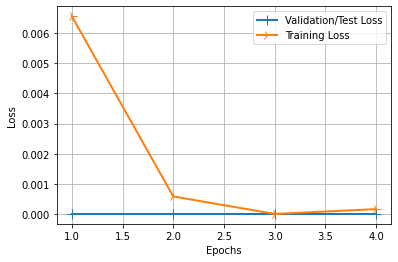

In [6]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

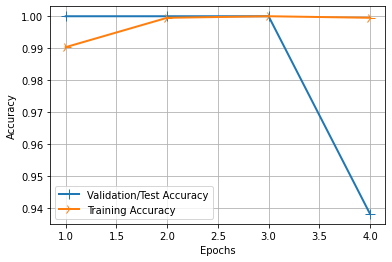

In [7]:
history_dict = history.history


acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Found 1182 images belonging to 2 classes.
Confusion Matrix
[[599   0]
 [  0 583]]
Classification Report
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       599
   BlueBerry       1.00      1.00      1.00       583

    accuracy                           1.00      1182
   macro avg       1.00      1.00      1.00      1182
weighted avg       1.00      1.00      1.00      1182



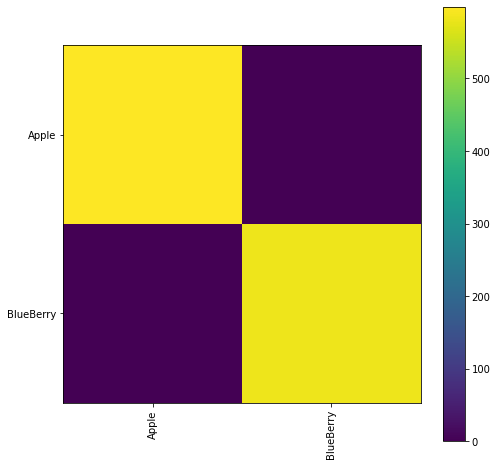

In [8]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 2103
nb_validation_samples =1182


validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        
        target_size=(img_rows, img_cols),
        batch_size=batch_size,

        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [2]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
from keras import models
import matplotlib.pyplot as plt
from keras.models import load_model
classifier = load_model('model/MobileNEt.h5')
#class_labels=['Apple','Curly']

Using TensorFlow backend.


[1.0000000e+00 2.2471518e-08]


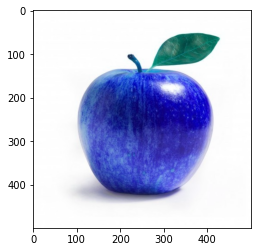

'Apple'

In [7]:
input_img = cv2.imread('/Users/rahulbadhan/Desktop/apple-shimla-500x500.jpeg')
test=cv2.resize(input_img,(224,224))
test = test.astype("float") / 255.0
test = np.array(test)
test = np.expand_dims(test, axis=0)
preds = classifier.predict(test)[0]
print(preds)
label=''
if preds[0]==1.0:
    label='Apple'
elif preds[1]>0.99:
    label= 'Other'
else:
    label='No Result Found'
    
label
plt.imshow(input_img)
plt.show()
label